In [1]:
# ==================== IMPORT LIBRARY ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

import warnings
warnings.filterwarnings("ignore")

In [4]:
# ==================== LOAD & INSPECT DATA ====================
df = pd.read_csv('clusteringcampaign.csv')

print("Shape Awal:", df.shape)
print("Info Kolom:")
print(df.info())
print("\nContoh Data:")
print(df.head())

Shape Awal: (2240, 1)
Info Kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                    Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                    --------------  ----- 
 0   ID	Year_Birth	Education	Marital_Status	Income	Kidhome	Teenhome	Dt_Customer	

In [5]:
# ==================== ENCODING + PREPROCESSING ====================
df_encoded = pd.get_dummies(df, drop_first=True)
df_clean = df_encoded.dropna()
print("Shape setelah encoding & dropna:", df_clean.shape)

Shape setelah encoding & dropna: (2240, 2239)


In [6]:
# ==================== NORMALISASI ====================
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_clean)

In [7]:
# ==================== PCA REDUKSI DIMENSI ====================
pca = PCA(n_components=3)  # bisa ubah ke 2 kalau mau visualisasi 2D
data_pca = pca.fit_transform(data_scaled)
print("Explained Variance Ratio PCA:", pca.explained_variance_ratio_)

Explained Variance Ratio PCA: [0.00044683 0.00044683 0.00044683]


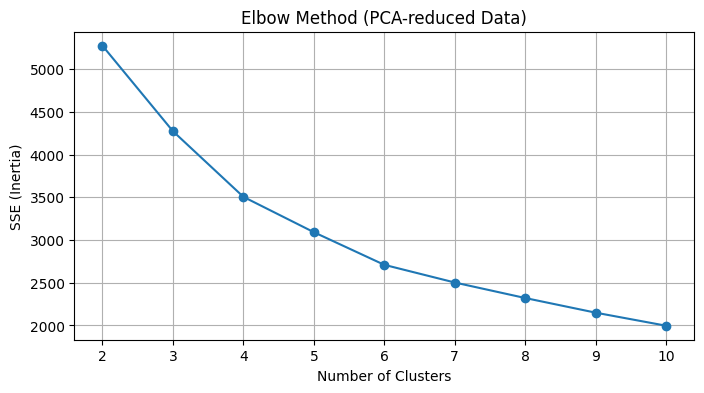

In [8]:
# ==================== ELBOW METHOD ====================
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method (PCA-reduced Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.show()


In [9]:
# ==================== DUNN INDEX FUNCTION ====================
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_clusters = np.unique(labels)
    min_intercluster = np.inf
    max_intracluster = 0

    for i in unique_clusters:
        cluster_i = np.where(labels == i)[0]
        for j in unique_clusters:
            if i != j:
                cluster_j = np.where(labels == j)[0]
                dist = np.min(distances[np.ix_(cluster_i, cluster_j)])
                if dist < min_intercluster:
                    min_intercluster = dist

    for i in unique_clusters:
        cluster_i = np.where(labels == i)[0]
        if len(cluster_i) > 1:
            intra_dist = np.max(distances[np.ix_(cluster_i, cluster_i)])
            if intra_dist > max_intracluster:
                max_intracluster = intra_dist

    return min_intercluster / max_intracluster

In [10]:
# ==================== EVALUASI CLUSTERING ====================
results = []

for n_clusters in range(2, 11):
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_km = km.fit_predict(data_pca)

    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels_agg = agg.fit_predict(data_pca)

    for name, labels in [('KMeans', labels_km), ('Agglomerative', labels_agg)]:
        silhouette = silhouette_score(data_pca, labels)
        ch = calinski_harabasz_score(data_pca, labels)
        db = davies_bouldin_score(data_pca, labels)
        dunn = dunn_index(data_pca, labels)

        results.append({
            'Model': name,
            'Clusters': n_clusters,
            'Silhouette': silhouette,
            'Calinski-Harabasz': ch,
            'Davies-Bouldin': db,
            'Dunn': dunn
        })

results_df = pd.DataFrame(results)
print("\n📊 Evaluation Metrics:")
print(results_df)


📊 Evaluation Metrics:
            Model  Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
0          KMeans         2    0.209584         614.576328        1.745195   
1   Agglomerative         2    0.174357         490.169914        1.868396   
2          KMeans         3    0.213388         640.844133        1.406937   
3   Agglomerative         3    0.152330         492.555650        1.625668   
4          KMeans         4    0.226911         684.074850        1.182368   
5   Agglomerative         4    0.158248         498.423338        1.425656   
6          KMeans         5    0.221022         656.280825        1.176779   
7   Agglomerative         5    0.157395         492.846795        1.410842   
8          KMeans         6    0.229411         661.836250        1.114713   
9   Agglomerative         6    0.154682         475.478512        1.320130   
10         KMeans         7    0.223054         627.632784        1.139005   
11  Agglomerative         7    0.155195  

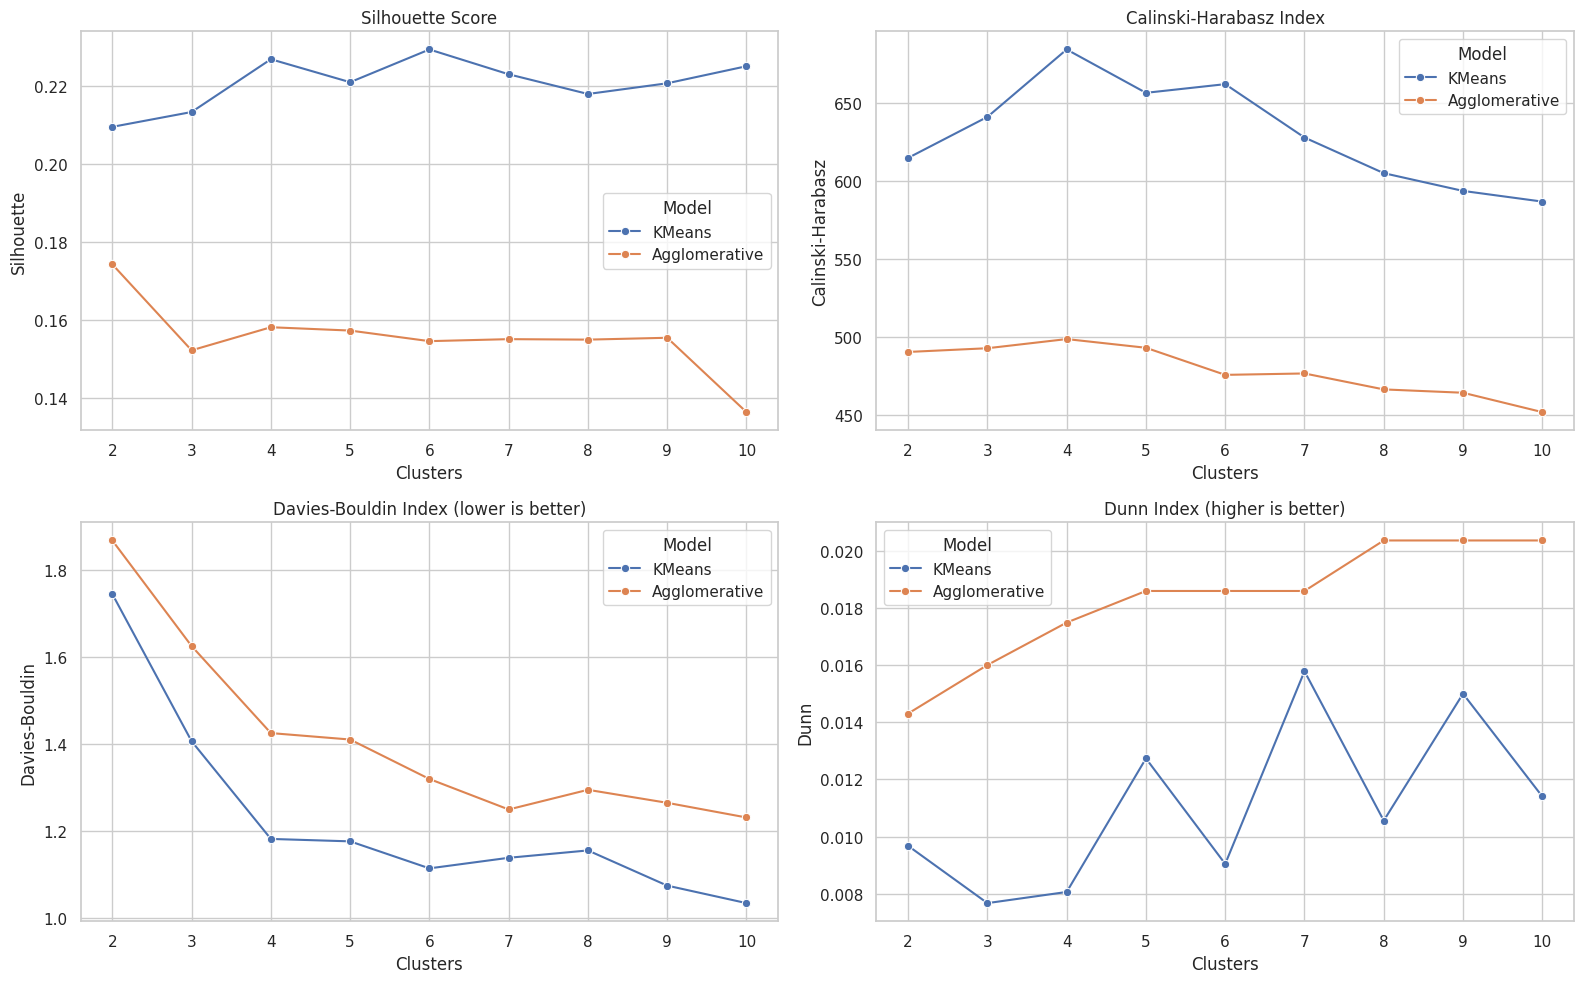

In [12]:
# ==================== VISUALISASI METRIK (TATA LETAK RAPI) ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set(style="whitegrid")

# Plot 1: Silhouette Score
sns.lineplot(data=results_df, x='Clusters', y='Silhouette', hue='Model', marker="o", ax=axes[0, 0])
axes[0, 0].set_title('Silhouette Score')
axes[0, 0].grid(True)

# Plot 2: Calinski-Harabasz Index
sns.lineplot(data=results_df, x='Clusters', y='Calinski-Harabasz', hue='Model', marker="o", ax=axes[0, 1])
axes[0, 1].set_title('Calinski-Harabasz Index')
axes[0, 1].grid(True)

# Plot 3: Davies-Bouldin Index
sns.lineplot(data=results_df, x='Clusters', y='Davies-Bouldin', hue='Model', marker="o", ax=axes[1, 0])
axes[1, 0].set_title('Davies-Bouldin Index (lower is better)')
axes[1, 0].grid(True)

# Plot 4: Dunn Index
sns.lineplot(data=results_df, x='Clusters', y='Dunn', hue='Model', marker="o", ax=axes[1, 1])
axes[1, 1].set_title('Dunn Index (higher is better)')
axes[1, 1].grid(True)

# Atur layout dan tampilkan
plt.tight_layout()
plt.show()


## 📐 Penjelasan Matematis Metrik Evaluasi Clustering

### 1. **Silhouette Coefficient**
Silhouette coefficient mengukur seberapa mirip sebuah titik dengan klusternya sendiri dibandingkan dengan kluster lain.

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

**Keterangan:**
- $a(i)$: Rata-rata jarak dari titik $i$ ke semua titik lain dalam klusternya sendiri  
- $b(i)$: Rata-rata jarak dari titik $i$ ke titik-titik di kluster terdekat lainnya  
- Nilai $s(i)$ berada di antara -1 dan 1:
  - $s(i) \approx 1$: Titik berada di kluster yang tepat  
  - $s(i) \approx 0$: Titik di antara dua kluster  
  - $s(i) \approx -1$: Titik salah tempat (mis-clustered)

---

### 2. **Calinski-Harabasz Index** *(Variance Ratio Criterion)*
Metrik ini membandingkan sebaran antar kluster dan dalam kluster.

$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

**Keterangan:**
- $\text{Tr}(B_k)$: Varians antar kluster (between-cluster dispersion)  
- $\text{Tr}(W_k)$: Varians dalam kluster (within-cluster dispersion)  
- $n$: Jumlah total data  
- $k$: Jumlah kluster  
- Semakin besar nilai $CH$, semakin baik pemisahan antar kluster

---

### 3. **Davies-Bouldin Index**
Metrik ini mengukur seberapa mirip kluster satu dengan lainnya.

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$

**Keterangan:**
- $\sigma_i$: Rata-rata jarak dari setiap titik dalam kluster $i$ ke centroid-nya  
- $d(c_i, c_j)$: Jarak antara centroid kluster $i$ dan $j$  
- Nilai yang lebih kecil menunjukkan cluster yang kompak dan saling berjauhan (lebih baik)

---

### 4. **Dunn Index**
Mengukur rasio antara jarak minimum antar kluster dengan diameter maksimum suatu kluster.

$$
D = \frac{\min\limits_{1 \leq i < j \leq k} d(c_i, c_j)}{\max\limits_{1 \leq l \leq k} \delta(C_l)}
$$

**Keterangan:**
- $d(c_i, c_j)$: Jarak minimum antar dua kluster yang berbeda  
- $\delta(C_l)$: Diameter dari kluster $l$ (jarak maksimum antar titik dalam satu kluster)  
- Semakin besar nilai Dunn Index, semakin baik pemisahan dan kekompakan kluster

---

### 📌 Kesimpulan Perbandingan Metrik

| **Metrik**              | **Interpretasi**                    |
|-------------------------|-------------------------------------|
| **Silhouette**          | Semakin tinggi, semakin baik        |
| **Calinski-Harabasz**   | Semakin tinggi, semakin baik        |
| **Davies-Bouldin**      | Semakin rendah, semakin baik        |
| **Dunn Index**          | Semakin tinggi, semakin baik        |


### 🔍 Kesimpulan Evaluasi Clustering

- **Silhouette Score** dan **Calinski-Harabasz Index** menunjukkan bahwa **KMeans** memberikan hasil yang lebih baik secara umum dibanding Agglomerative Clustering.
- **Davies-Bouldin Index** lebih rendah pada KMeans, menandakan pemisahan antar cluster lebih bagus.
- **Dunn Index** juga lebih tinggi pada KMeans, menandakan jarak antar cluster besar relatif terhadap diameter dalam cluster.

**Kesimpulan:** Model **KMeans** lebih optimal dalam memisahkan dan membentuk cluster pada dataset ini.
